In [1]:
import numpy as np
from collections import *
import pickle
import heapq
import logging
logging.basicConfig(level=logging.INFO)
import gc
import random
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def load_graph():
    with open('graph.pkl', 'rb') as fd:
        return pickle.load(fd)

def load_words():
    with open('words.pkl', 'rb') as fd:
        return pickle.load(fd)

In [3]:
graph = load_graph()
words = load_words()

In [4]:
len(words)

379557

In [5]:
def generate(word):
    yield from [
        word[:i] + '_' + word[i+1:]
        for i in range(len(word))
    ]

In [6]:
def bfs(begin, end, words, graph_):
    assert not {begin, end} - words
    assert len(begin) == len(end)
    graph = graph_[len(begin)]
    
    queue = deque([(begin, [begin])])
    visited = set([begin])
    
    iterations = 0
    while queue:
        w, path = queue.popleft()
        if w == end:
            logging.info("w1=%s w2=%s path=%s", begin, end, path)
            return {"length": len(path), "iterations": iterations}
        for pattern in generate(w):
            delta = graph[pattern] - visited
            queue.extend([(d, path+[d]) for d in delta])
            visited.update(delta)
        iterations += 1
    return {"length": float('inf'), "iterations": iterations}

In [7]:
bfs('fast', 'slow', words, graph)

{'length': 6, 'iterations': 5970}

In [21]:
def bfs_step(queue, visited, graph):
    q2 = deque()
    iterations = 0
    while queue:
        w, path = queue.popleft()
        for pattern in generate(w):
            delta = graph[pattern] - visited
            visited.update(delta)
            q2.extend([[nw, path + [nw]] for nw in delta])
        iterations += 1
    return q2, iterations


def bi_bfs(begin, end, words, graph_):
    assert not {begin, end} - words
    assert len(begin) == len(end)
    graph = graph_[len(begin)]

    q1 = deque([[begin, [begin]]])
    q2 = deque([[end, [end]]])
    
    v1 = set([begin])
    v2 = set([end])

    iterations = 0
    while q1 and q2:
        if v1.intersection(v2):
            _, path1 = q1.popleft()
            _, path2 = q2.popleft()
            path = path1 + path2[::-1]
            logging.info("w1=%s w2=%s path=%s", begin, end, path)
            return {"length": len(path), "iterations": iterations}

        if len(q1) <= len(q2):
            q1, it = bfs_step(q1, v1, graph)
        else:
            q2, it = bfs_step(q2, v2, graph)
        iterations += it
    
    return {"length": float('inf'), "iterations": iterations}

In [22]:
bi_bfs('found', 'after', words, graph)

INFO:root:w1=found w2=after path=['found', 'wound', 'would', 'could', 'cauld', 'bauld', 'liter', 'later', 'oater', 'ofter', 'after']


{'length': 11, 'iterations': 241}

In [23]:
def astar(start, end, words, graph_, heuristic):
    assert not {start, end} - words
    assert len(start) == len(end)

    pq = [[heuristic(start, end), 0, start, [start]]]
    visited = set()
    graph = graph_[len(start)]

    iterations = 0
    while pq:
        _, cost, w, path = heapq.heappop(pq)
        if w == end: 
            logging.info("w1=%s w2=%s path=%s", start, end, path)
            return {"length": len(path), "iterations": iterations}
        for p in generate(w):
            delta = graph[p] - visited
            visited.update(delta)
            priorities = [cost + heuristic(w, end) for w in delta]
            pq.extend([(p, 1+cost, w, path + [w]) for w, p in zip(delta, priorities)])
        heapq.heapify(pq)
        iterations += 1
    
    return {"length": float('inf'), "iterations": iterations}

def heuristic(w, w2):
    return sum([a != b for a, b in zip(w, w2)])


In [24]:
astar('after', 'found', words, graph, heuristic)

INFO:root:w1=after w2=found path=['after', 'aster', 'mster', 'moter', 'motes', 'moues', 'mouls', 'mould', 'mound', 'found']


{'length': 10, 'iterations': 820}

In [25]:
def bi_astar(start, end, words, graph_, heuristic):
    assert not {start, end} - words
    assert len(start) == len(end)

    graph = graph_[len(start)]

    pq1 = [(heuristic(start, end), 0, start, [start])]
    pq2 = [(heuristic(end, end), 0, end, [end])]

    v1, v2 = set(), set()
    iterations = 0

    while pq1 and pq2:
        if v1.intersection(v2):
            *_, path1 = pq1[0]
            *_, path2 = pq2[0]
            path = path1 + path2[::-1]
            logging.info("w1=%s w2=%s path=%s", start, end, path)
            return {"length": len(path), "iterations": iterations}
        
        it = 0

        if len(pq1) <= len(pq2):
            pq1_ = []
            while pq1:
                it += 1
                _, c1, w1, path1 = heapq.heappop(pq1)

                for p in generate(w1):  
                    delta = graph[p] - v1
                    v1.update(delta)
                    priorities = [c1 + heuristic(w, end) for w in delta]
                    pq1_.extend([(p, 1+c1, w, path1 + [w]) for w, p in zip(delta, priorities)])
            pq1 = pq1_
            heapq.heapify(pq1)

        else:
            pq2_ = []
            while pq2:
                it += 1
                _, c2, w2, path2 = heapq.heappop(pq2)
                
                for p in generate(w2):
                    delta = graph[p] - v2
                    v2.update(delta)
                    priorities = [c2 + heuristic(w, end) for w in delta]
                    pq2_.extend([(p, 1+c2, w, path2 + [w]) for w, p in zip(delta, priorities)])
            pq2 = pq2_
            heapq.heapify(pq2)

        iterations += it
    return {"length": float('inf'), "iterations": iterations}

In [26]:
bi_astar('after', 'found', words, graph, heuristic)

INFO:root:w1=after w2=found path=['after', 'aster', 'mster', 'moter', 'moted', 'fauld', 'cauld', 'could', 'mould', 'mound', 'found']


{'length': 11, 'iterations': 243}

In [27]:
lw = list(words)
word_map = defaultdict(list)

for w in lw:
    word_map[len(w)].append(w)

samples = defaultdict(list)
samples2 = defaultdict(list)

for r in range(5, 11):
    samples[r] = [random.choice(word_map[r]) for _ in range(10)]
    samples2[r] = [random.choice(word_map[r]) for _ in range(10)]

print(samples)
print(samples2)

defaultdict(<class 'list'>, {5: ['alane', 'deddy', 'linne', 'bagie', 'shako', 'snipe', 'kecks', 'getic', 'facet', 'asyle'], 6: ['guanin', 'rapped', 'carapo', 'weirds', 'villar', 'minnow', 'querre', 'calkin', 'staker', 'schrik'], 7: ['disrobe', 'gaudier', 'integer', 'novelle', 'buckled', 'cotutor', 'etymons', 'grizard', 'clauses', 'pateria'], 8: ['carbides', 'volaille', 'plumpers', 'nosewing', 'grapples', 'tallaism', 'saxonize', 'picklock', 'dulcimer', 'serenize'], 9: ['outfacing', 'acanthoma', 'underplay', 'morpholin', 'viaticals', 'inbreeder', 'recongest', 'nonparent', 'lutenists', 'roughhews'], 10: ['pragmatics', 'compacting', 'neomorphic', 'glairiness', 'mistletoes', 'samiresite', 'disyllabic', 'pachyaemia', 'osteologic', 'matachinas']})
defaultdict(<class 'list'>, {5: ['yesso', 'aiery', 'eryon', 'dault', 'plots', 'orary', 'peize', 'dozen', 'batan', 'marsi'], 6: ['ergane', 'abucco', 'wickup', 'tetric', 'preman', 'hearty', 'commis', 'calxes', 'thring', 'mudhif'], 7: ['goatpox', 'cata

In [52]:
def performance(samples, samples2):
    starts = []
    ends = []

    vbfs = []
    vbi_bfs = []
    vastar = []
    vbiastar = []

    ibfs = []
    ibi_bfs = []
    iastar = []
    ibinastar = []

    for length in range(5, 11):
        logging.info("length=%d", length)

        s1 = samples[length]
        s2 = samples2[length]

        for w1, w2 in zip(s1, s2):
            starts.append(w1)
            ends.append(w2)
            length, it = bfs(w1, w2, words, graph).items()
            vbfs.append(length[1])
            ibfs.append(it[1])

            length, it = bi_bfs(w1, w2, words, graph).items()
            vbi_bfs.append(length[1])
            ibi_bfs.append(it[1])

            length, it = astar(w1, w2, words, graph, heuristic).items()
            vastar.append(length[1])
            iastar.append(it[1])

            length, it = bi_astar(w1, w2, words, graph, heuristic).items()
            vbiastar.append(length[1])
            ibinastar.append(it[1])

    return pd.DataFrame({
        "starts": starts,
        "ends": ends,
        "bfs-iterations": ibfs,
        "bfs-lengths": vbfs,
        'bi-bfs-iterations': ibi_bfs,
        'bi-bfs-lengths': vbi_bfs,
        'astar-iterations': iastar,
        'astar-lengths': vastar,
        'bi-astar-iterations': ibinastar,
        'bi-astar-lengths': vbiastar
    })

In [57]:
df = performance(samples, samples2)

INFO:root:length=5
INFO:root:w1=deddy w2=aiery path=['deddy', 'reddy', 'ruddy', 'rudds', 'lairy', 'fairy', 'faery', 'fiery', 'aiery']
INFO:root:w1=deddy w2=aiery path=['deddy', 'deady', 'deary', 'derry', 'ferry', 'firry', 'fiery', 'aiery']
INFO:root:w1=deddy w2=aiery path=['deddy', 'diddy', 'biddy', 'bidry', 'abort', 'aport', 'apert', 'apery', 'aiery']
INFO:root:w1=linne w2=eryon path=['linne', 'tinne', 'tonne', 'gonne', 'gonna', 'freen', 'freon', 'creon', 'croon', 'broon', 'bryon', 'eryon']
INFO:root:w1=linne w2=eryon path=['linne', 'tinne', 'tonne', 'bonne', 'boone', 'boonk', 'bronk', 'brook', 'broon', 'bryon', 'eryon']
INFO:root:w1=linne w2=eryon path=['linne', 'linns', 'linos', 'lidos', 'eidos', 'exxon', 'exion', 'axion', 'arion', 'argon', 'ergon', 'eryon']
INFO:root:w1=bagie w2=dault path=['bagie', 'bogie', 'logie', 'louie', 'trust', 'frust', 'faust', 'fault', 'dault']
INFO:root:w1=bagie w2=dault path=['bagie', 'bagne', 'pagne', 'paine', 'paint', 'daint', 'daunt', 'dault']
INFO:ro

In [58]:
df.head(50)

,starts,ends,bfs-iterations,bfs-lengths,bi-bfs-iterations,bi-bfs-lengths,astar-iterations,astar-lengths,bi-astar-iterations,bi-astar-lengths
0,alane,yesso,15181,inf,3,inf,15182,inf,4,inf
1,deddy,aiery,8301,8.0,95,9.0,234,8.0,97,9.0
2,linne,eryon,14078,11.0,520,12.0,3274,11.0,522,12.0
3,bagie,dault,6854,8.0,132,9.0,289,8.0,134,9.0
4,shako,plots,2494,7.0,115,8.0,21,7.0,117,8.0
5,snipe,orary,3077,7.0,57,8.0,44,7.0,59,8.0
6,kecks,peize,4537,7.0,97,8.0,69,7.0,99,8.0
7,getic,dozen,5290,8.0,139,9.0,53,8.0,141,9.0
8,facet,batan,2210,6.0,70,7.0,13,6.0,72,7.0
9,asyle,marsi,7000,11.0,519,12.0,276,11.0,521,12.0


Text(0, 0.5, '#Iterations')

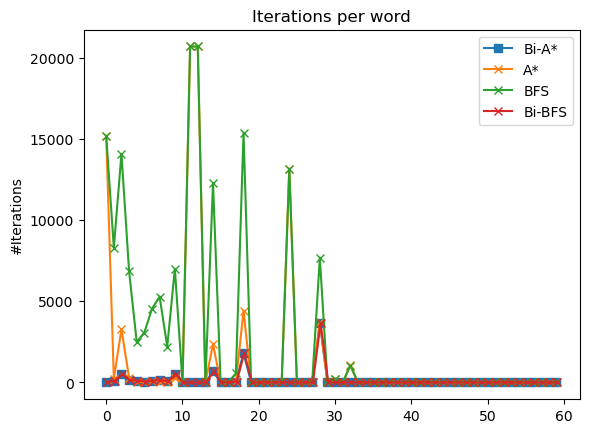

In [59]:
R = np.arange(0, 60)
plt.plot(R, df['bi-astar-iterations'], marker='s')
plt.plot(R, df['astar-iterations'], marker='x')
plt.plot(R, df['bfs-iterations'], marker='x')
plt.plot(R+1e-1, df['bi-bfs-iterations'], marker='x')
plt.legend(['Bi-A*', 'A*', 'BFS', 'Bi-BFS'])
plt.title('Iterations per word')
plt.ylabel('#Iterations')

Text(0, 0.5, '#Lengths')

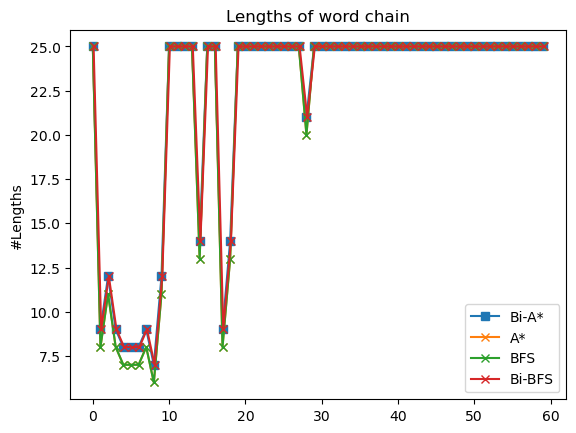

In [60]:
df2 = df.copy()
df.replace([np.inf, -np.inf], 25, inplace=True)
df.dropna(inplace=True)
R = np.arange(0, len(df))

plt.plot(R, df['bi-astar-lengths'], marker='s')
plt.plot(R, df['astar-lengths'], marker='x')
plt.plot(R, df['bfs-lengths'], marker='x')
plt.plot(R+1e-1, df['bi-bfs-lengths'], marker='x')
plt.legend(['Bi-A*', 'A*', 'BFS', 'Bi-BFS'])
plt.title('Lengths of word chain')
plt.ylabel('#Lengths')